# YouTube Metadata Analysis
Here we go and analyze YouTube metadata as upload behaviour for example.

## Imports
Import matplotlib package and configure some plot drawing variables.

In [2]:
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = r"\usepackage{type1cm}"

## Load data

In [3]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("../rsc/caption_party.db")
data = pd.read_sql("SELECT * from tab", conn)

data['publishedAt'] = pd.DatetimeIndex(data['publishedAt'])
data['updated'] = pd.DatetimeIndex(data['updated'])

data['viewCount'] = pd.to_numeric(data['viewCount'], downcast='unsigned')
data['commentCount'] = pd.to_numeric(data['commentCount'], downcast='unsigned', errors='coerce')

data.set_index('videoId', inplace=True)

## Variables
### Dates and periods

In [4]:
from datetime import datetime as time, timedelta
import pytz

cest = pytz.timezone("Europe/Berlin")

bt_election = time.fromisoformat('2017-09-24').replace(tzinfo=cest)
eu_election = time.fromisoformat('2019-05-26').replace(tzinfo=cest)

bt_start = bt_election - timedelta(days=90)
eu_start = eu_election - timedelta(days=90)
bt_end = bt_election + timedelta(days=90)
eu_end = eu_election + timedelta(days=90)

bt_period = (bt_start <= data['publishedAt']) & (data['publishedAt'] <= bt_end)
eu_period = (eu_start <= data['publishedAt']) & (data['publishedAt'] <= eu_end)

bt_data = data[bt_period]
eu_data = data[eu_period]

### Parties and elections

In [5]:
parties = ['union', 'spd', 'afd', 'fdp', 'linke', 'grüne']
elections = ['bt', 'eu']

### Colors

In [6]:
import matplotlib.colors as mc
import colorsys

def scale_color(color, amount=0.5):
    c_hls = colorsys.rgb_to_hls(*mc.to_rgb(color))
    c_rgb = colorsys.hls_to_rgb(c_hls[0], 1 - amount * (1 - c_hls[1]), c_hls[2])
    return mc.to_hex(c_rgb)

colors = {
    'union': '#252422',
    'spd':   '#e2001a',
    'afd':   '#009ee0',
    'fdp':   '#ffec01',
    'linke': '#ffa7b6',
    'grüne': '#42923b'}

colors_light = {key: scale_color(color, 0.35) for key, color in colors.items()}

## Visualization

In [7]:
from matplotlib.ticker import MaxNLocator

def barplot(data, label):
    fig = plt.figure()
    ax = fig.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(color='gray', linestyle='dashed', alpha=0.3, axis='y')
    ax.set_ylabel(label);

    color_map = [colors[party] for party in parties]
    ax.bar(parties, channel_count[parties], color=color_map, width=.8)
    return fig

def compare_fig(bt_data, eu_data, label):
    fig = plt.figure()
    ax = fig.gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_ylabel(label);
    ax.grid(color='gray', linestyle='dashed', alpha=0.3, axis='y')
    color_map_dark = [colors[party] for party in parties]
    color_map_light = [colors_light[party] for party in parties]
    ax.bar(parties, bt_data[parties], color=color_map_dark, width=-.4, align='edge', label='Bundestag election')
    ax.bar(parties, eu_data[parties], color=color_map_light, width=.4, align='edge', label='European election')
    return fig

## Plotting

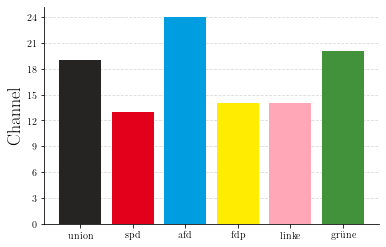

In [8]:
channel_count = data.groupby('party').nunique()['channelId']

fig = barplot(channel_count, 'Channel')
fig.savefig('outputs/channel-count.pdf', bbox_inches = 'tight', pad_inches = 0)

## Video count

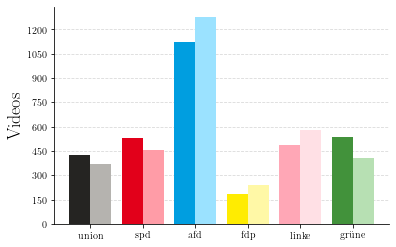

In [9]:
bt_video_count = data[bt_period].groupby('party').nunique()['title']
eu_video_count = data[eu_period].groupby('party').nunique()['title']

fig = compare_fig(bt_video_count, eu_video_count, 'Videos')
plt.savefig('outputs/yt-party-videos.pdf', bbox_inches = 'tight', pad_inches = 0)

## Missing subtitles count

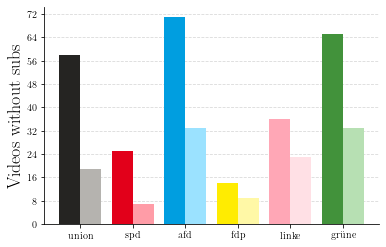

In [10]:
bt_msubtitle_count = data[bt_period].groupby('party')['subtitle'].apply(lambda df: sum(df.apply(lambda x: len(x) < 10)))
eu_msubtitle_count = data[eu_period].groupby('party')['subtitle'].apply(lambda df: sum(df.apply(lambda x: len(x) < 10)))
fig = compare_fig(bt_msubtitle_count, eu_msubtitle_count, 'Videos without subs')
fig.savefig('outputs/videos-without-subs-count.pdf', bbox_inches = 'tight', pad_inches = 0)

### Upload analysis

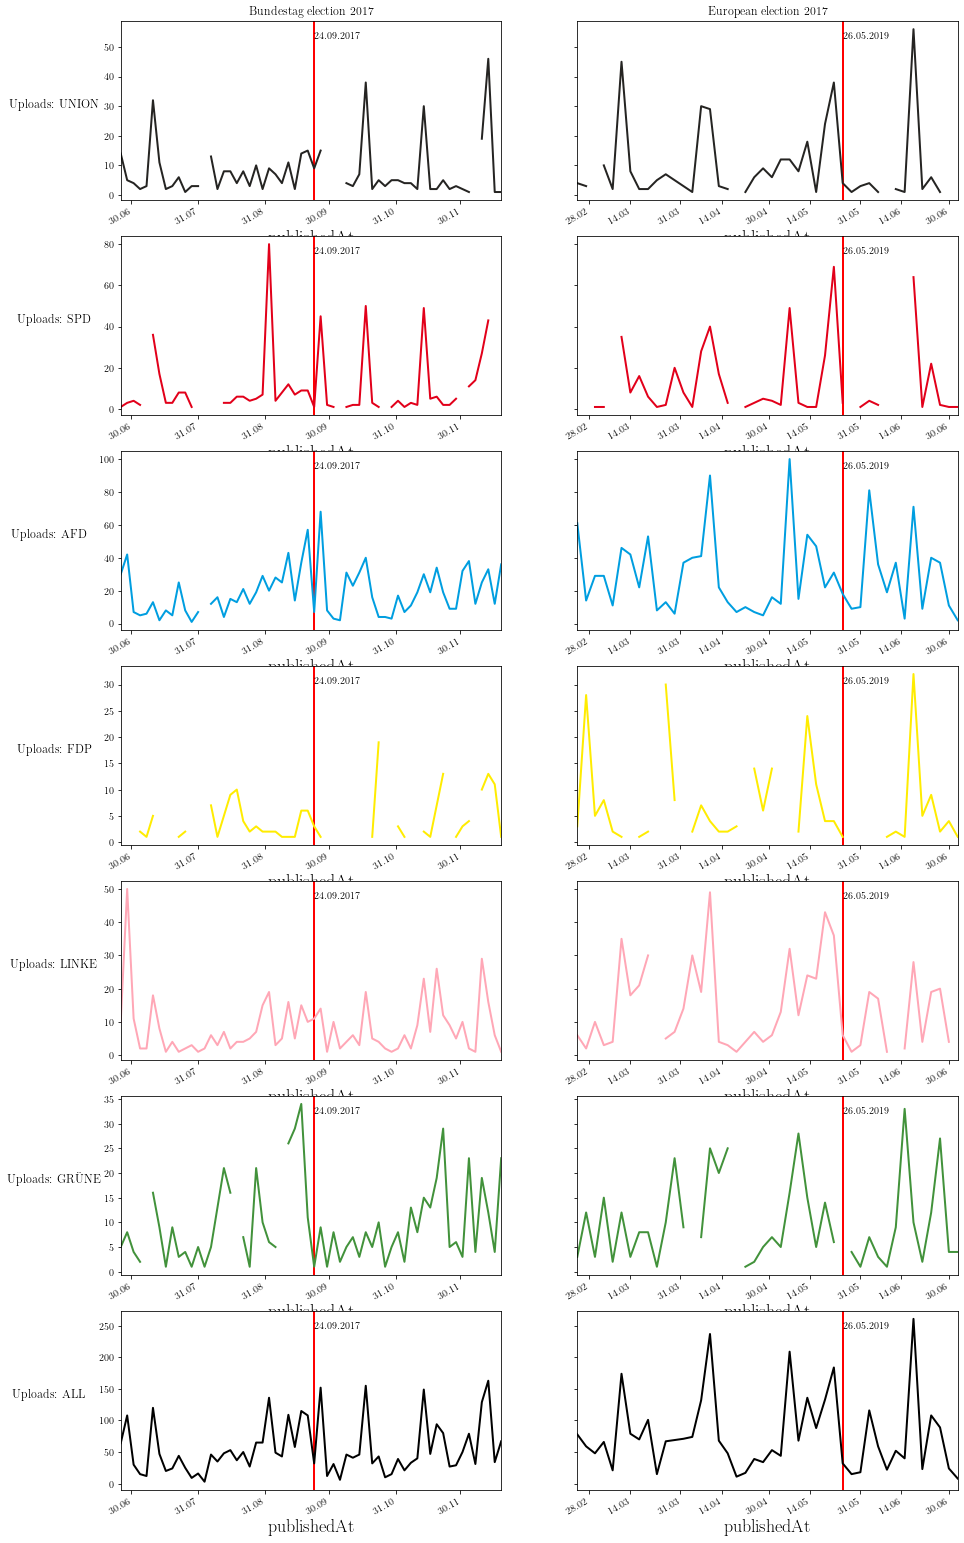

In [17]:
import matplotlib.dates as mdates

upload_count = data[bt_period|eu_period].groupby([pd.Grouper(key='publishedAt', freq='3d'), data['party']])['title'].count().unstack()
f, ax = plt.subplots(len(parties)+1,2, figsize=(15,30), sharey='row')
for ix,party in enumerate(parties + [parties]):
    axL = ax[ix][0]
    axR = ax[ix][1]
    if type(party) is list:
        title = 'Uploads: ALL'
        color = 'black'
        uploads = upload_count[party].sum(axis=1)
    else:
        title = 'Uploads: ' + party.upper()
        color = colors[party]
        uploads = upload_count[party]
    if ix == 0:
        axL.set_title('Bundestag election 2017', size='large')
        axR.set_title('European election 2017', size='large')
    axL.axvline(x=bt_election, c='red')
    axR.axvline(x=eu_election, c='red')
    axL.annotate(" 24.09.2017", xy=(bt_election,.9), xycoords=("data", "axes fraction"))
    axR.annotate(" 26.05.2019", xy=(eu_election,.9), xycoords=("data", "axes fraction"))
    axL.set_ylabel(title, rotation=0, size='large', labelpad=50)
    uploads[bt_start:bt_end].plot(color=color, ax=axL)
    uploads[eu_start:eu_end].plot(color=color, ax=axR)
    axL.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
    axR.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))

### View count analysis

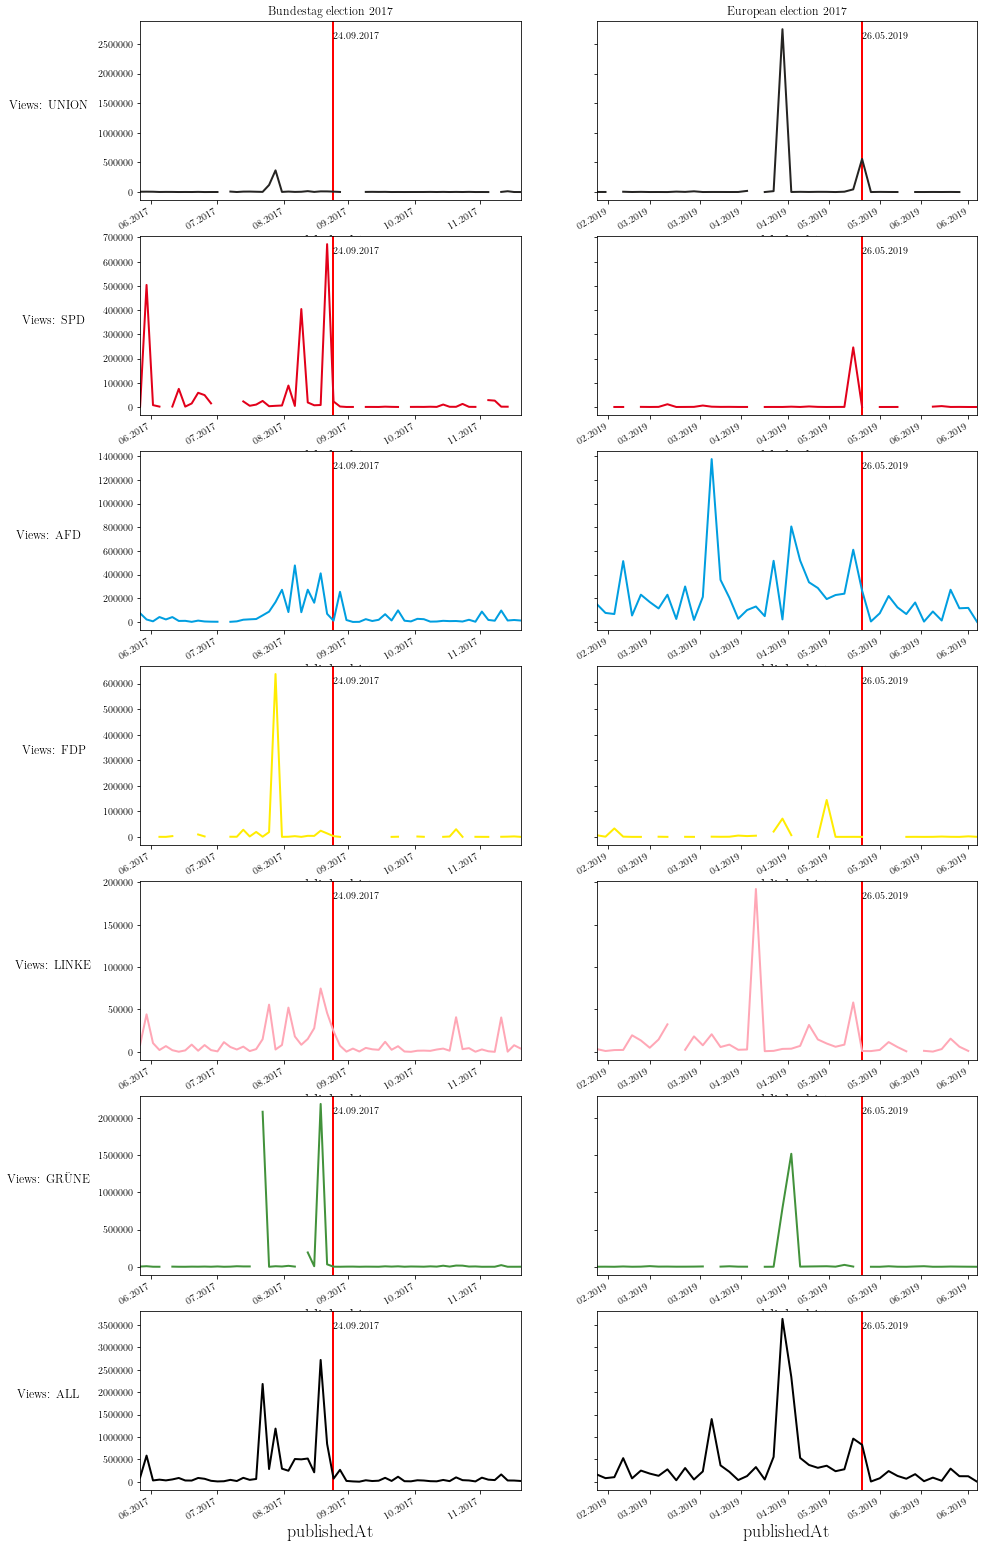

In [18]:
view_count = data[bt_period|eu_period].groupby([pd.Grouper(key='publishedAt', freq='3d'), data['party']])['viewCount'].sum().unstack()
f, ax = plt.subplots(len(parties)+1,2, figsize=(15,30), sharey='row')
for ix,party in enumerate(parties + [parties]):
    axL = ax[ix][0]
    axR = ax[ix][1]
    if type(party) is list:
        title = 'Views: ALL'
        color = 'black'
        views = view_count[party].sum(axis=1)
    else:
        title = 'Views: ' + party.upper()
        color = colors[party]
        views = view_count[party]
    if ix == 0:
        axL.set_title('Bundestag election 2017', size='large')
        axR.set_title('European election 2017', size='large')
    axL.axvline(x=bt_election, c='red')
    axR.axvline(x=eu_election, c='red')
    axL.annotate(" 24.09.2017", xy=(bt_election,.9), xycoords=("data", "axes fraction"))
    axR.annotate(" 26.05.2019", xy=(eu_election,.9), xycoords=("data", "axes fraction"))
    axL.set_ylabel(title, rotation=0, size='large', labelpad=50)
    views[bt_start:bt_end].plot(color=color, ax=axL)
    views[eu_start:eu_end].plot(color=color, ax=axR) 
    axL.xaxis.set_major_formatter(mdates.DateFormatter('%m.%Y'))
    axR.xaxis.set_major_formatter(mdates.DateFormatter('%m.%Y'))

### Comment count analysis

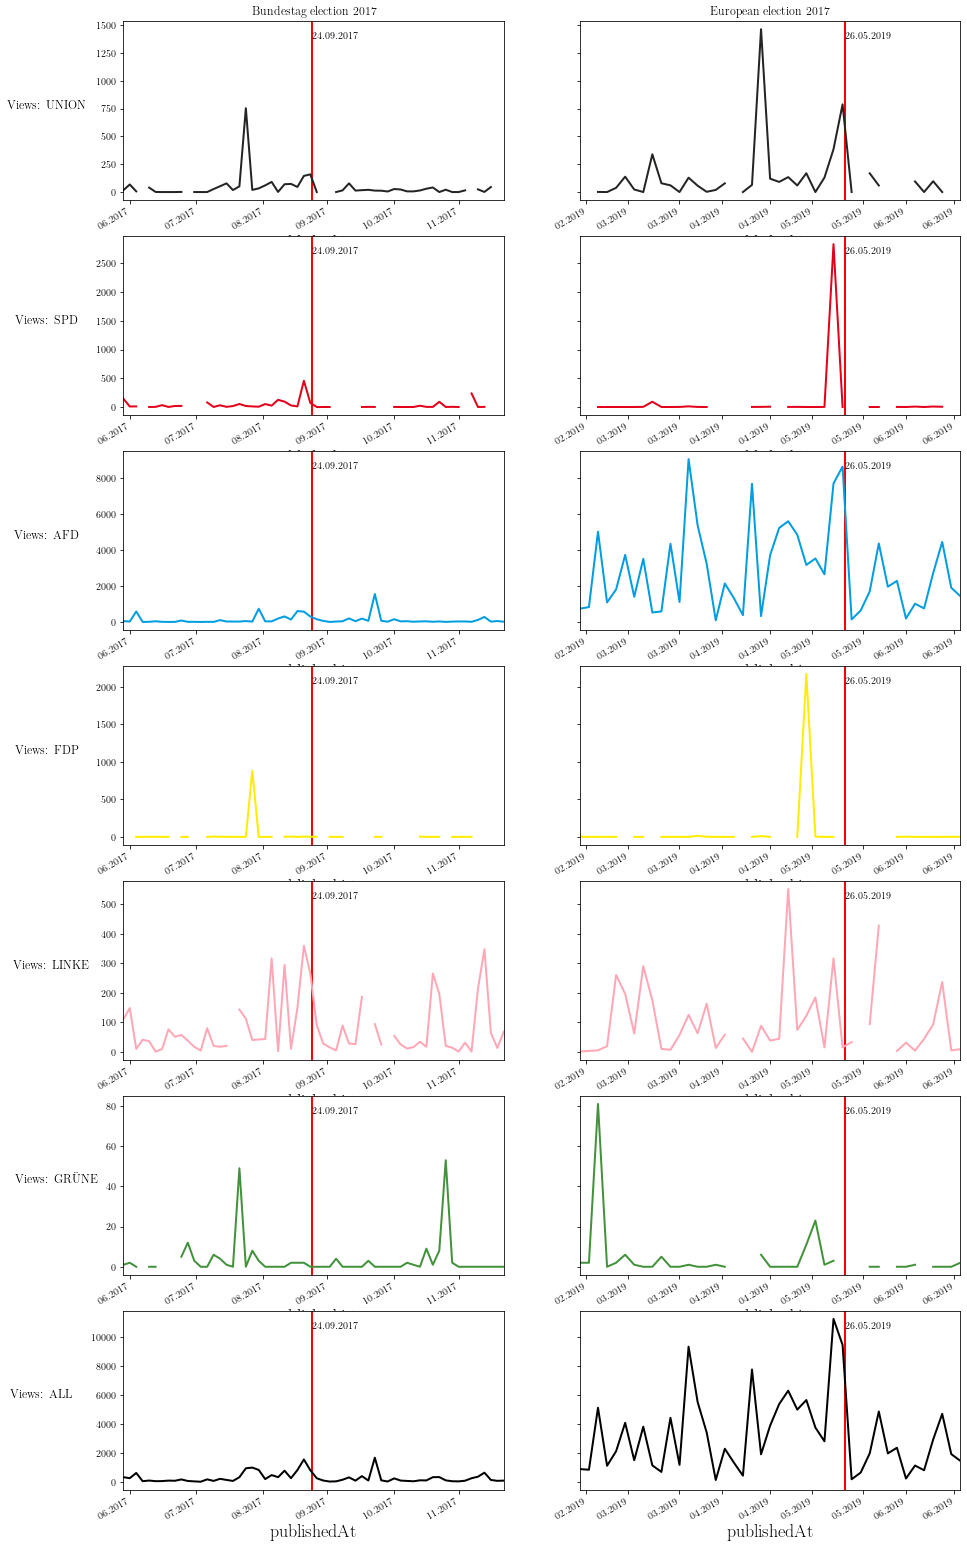

In [19]:
view_count = data.groupby([pd.Grouper(key='publishedAt', freq='3d'), data['party']])['commentCount'].sum().unstack()
f, ax = plt.subplots(len(parties)+1,2, figsize=(15,30), sharey='row')
for ix,party in enumerate(parties + [parties]):
    axL = ax[ix][0]
    axR = ax[ix][1]
    if type(party) is list:
        title = 'Views: ALL'
        color = 'black'
        views = view_count[party].sum(axis=1)
    else:
        title = 'Views: ' + party.upper()
        color = colors[party]
        views = view_count[party]
    if ix == 0:
        axL.set_title('Bundestag election 2017', size='large')
        axR.set_title('European election 2017', size='large')
    axL.axvline(x=bt_election, c='red')
    axR.axvline(x=eu_election, c='red')
    axL.annotate(" 24.09.2017", xy=(bt_election,.9), xycoords=("data", "axes fraction"))
    axR.annotate(" 26.05.2019", xy=(eu_election,.9), xycoords=("data", "axes fraction"))
    axL.set_ylabel(title, rotation=0, size='large', labelpad=50)
    views[bt_start:bt_end].plot(color=color, ax=axL)
    views[eu_start:eu_end].plot(color=color, ax=axR) 
    axL.xaxis.set_major_formatter(mdates.DateFormatter('%m.%Y'))
    axR.xaxis.set_major_formatter(mdates.DateFormatter('%m.%Y'))

/usr/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
/usr/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


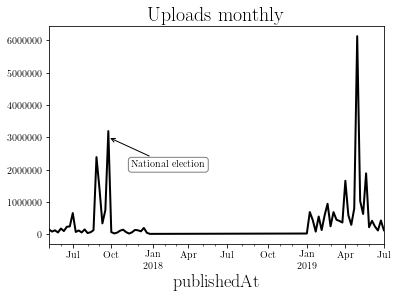

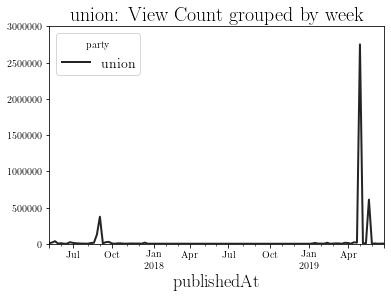

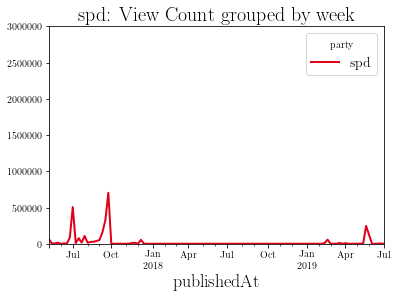

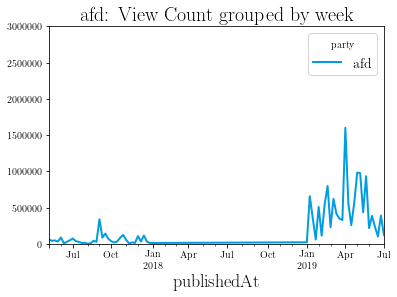

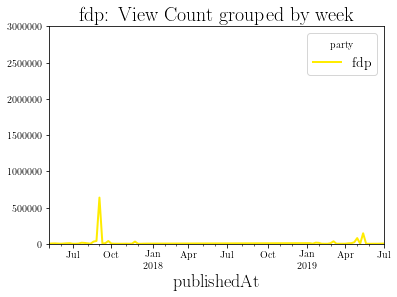

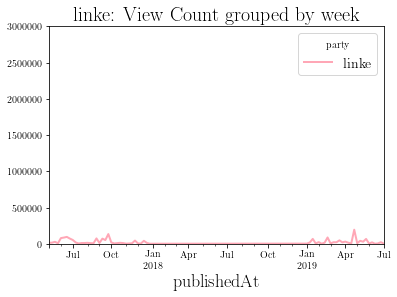

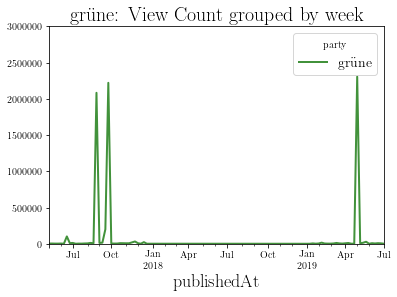

In [16]:
style = dict(size=10, color='gray')
plt.title("Uploads monthly")
count_month = data.groupby(data["publishedAt"].dt.to_period('W'))[
    'viewCount'].sum()
plt.annotate("National election", xy=('2017-09-24', 3000000),  xycoords='data', bbox=dict(boxstyle="round", fc="none", ec="gray"), xytext=(60, -30), textcoords='offset points', ha='center', arrowprops=dict(arrowstyle="->"))
count_month.plot(color='black');

for party in parties:
    count_party_month = data[data['party'] == party].groupby([data["publishedAt"].dt.to_period('W'), data['party']])['viewCount'].sum().unstack()
    count_party_month.plot(color=colors[party])
    plt.title(party + ": View Count grouped by week")
    plt.axis([None, None, 0, 3000000])

/usr/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


TypeError: Cannot compare tz-naive and tz-aware datetime-like objects

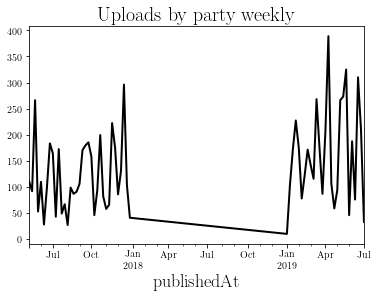

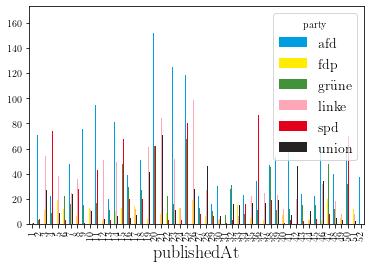

In [17]:
plt.title("Uploads weekly")
count_week = data.groupby(data["publishedAt"].dt.to_period('W'))[
    'title'].count()
count_week.plot(color='black')
# WEEKLY
plt.title("Uploads by party weekly")
count_party_week = data.groupby([data["publishedAt"].dt.week, data['party']])[
    'title'].count().unstack()
count_party_week.plot(color=count_party_week.apply(
    lambda x: colors[x.name]), kind='bar')

data[data['publishedAt'] > '10.10.2017']['publishedAt']

peak2 = data.query(
    'publishedAt > "10.10.2017" and publishedAt < "10.20.2017"').index
for title in data.loc[peak2]['title']:
    print(title)


In [ ]:
count = data.groupby([data["publishedAt"].dt.week, data['party']])['title'].count().unstack()
count.plot(color=count.apply(lambda x: colors[x.name]))

## ViewCount

In [ ]:
data.sort_values('viewCount')[['title', 'channelTitle','publishedAt','viewCount']]

## CommentCount

In [ ]:
data[['title', 'channelTitle','publishedAt','viewCount', 'commentCount']].sort_values('commentCount', ascending=False)

In [ ]:
data['publishedAt'] = pd.to_datetime(data['publishedAt']) 

In [ ]:
viewCount = data.groupby([data["publishedAt"].dt.month, data['party']]).sum()['viewCount'].unstack()
viewCount

In [ ]:
count = data.groupby([data["publishedAt"].dt.week, data['party']])['title'].count().unstack()
count.plot(color=count.apply(lambda x: colors[x.name]))

In [ ]:
count.sum()

In [ ]:
viewCount.plot(kind='bar', color=viewCount.apply(lambda x: colors[x.name]))

In [ ]:
data.columns